In [ ]:
#Libraries
from typing import Optional, Any
import warnings
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tifffile import TiffFile, TiffWriter
import numpy as np
import pandas as pd
import os
from google.colab import drive
from sklearn  import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestCentroid
from joblib import dump, load
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
# Import the function for reading an image
from skimage.io import imread
from skimage.color import rgb2yiq
from skimage.color import rgb2gray
from sklearn.preprocessing import label_binarize

import h5py

import cv2
from skimage.exposure import equalize_hist
from matplotlib import pyplot
from matplotlib import colors as cls

import numpy as np

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf

from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# Mounting drive for reflectance images
# drive.mount('/content/drive')

#Reference
#https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html 
#https://datascience.stackexchange.com/questions/28493/confusion-matrix-get-items-fp-fn-tp-tn-python/28502

#https://stackoverflow.com/questions/32838802/numpy-with-python-convert-3d-array-to-2d 

Mounted at /content/drive


# READSTIFF AND READMTIFF FUNCTIONS

In [ ]:
def read_mtiff(filename):
    """
    Read a mask bitmap tiff.

    Mask bitmap tiff contains multiple pages of bitmap masks. The mask label
    is stored in tag 65001 in each page. The mask label is stored as an ASCII
    string that may contain unicode codepoints encoded as ASCII character
    sequences (see unicode-esca                                                         pe encoding in Python docs).

    :param filename:    filename of the mask tiff to read.
    :return:            Dict[label: str, mask: ndarray], where
                        label: the mask label
                        mask: the boolean bitmap associated with the label.
    """
    TIFFTAG_MASK_LABEL = 65001
    masks = dict()
    with TiffFile(filename) as tiff:
        for p in range(0, len(tiff.pages)):
            label_tag = tiff.pages[p].tags.get(TIFFTAG_MASK_LABEL)
            if label_tag is None:
                if p > 0:
                    print(f'** page {p}: no TIFF_MASK_LABEL tag. Ignored.')
                continue
            label = label_tag.value.encode('ascii').decode('unicode-escape')
            mask = tiff.asarray(key=p)
            masks[label] = mask > 0
    return masks


In [ ]:

def read_stiff(filename: str, silent=False, rgb_only=False):
    """
    :param filename:    filename of the spectral tiff to read.
    :return:            Tuple[spim, wavelengths, rgb, metadata], where
                        spim: spectral image cube of form [height, width, bands],
                        wavelengths: the center wavelengths of the bands,
                        rgb: a color render of the spectral image [height, width, channels] or None
                        metadata: a free-form metadata string stored in the image, or an empty string
    """
    TIFFTAG_WAVELENGTHS = 65000
    TIFFTAG_METADATA = 65111
    spim = None
    wavelengths = None
    rgb = None
    metadata = None

    first_band_page = 0
    with TiffFile(filename) as tiff:
        # The RGB image is optional, the first band image maybe on the first page:
        first_band_page = 0
        if tiff.pages[first_band_page].ndim == 3:
            rgb = tiff.pages[0].asarray()
            # Ok, the first band image is on the second page
            first_band_page = first_band_page + 1

        multiple_wavelength_lists = False
        multiple_metadata_fields = False
        for band_page in range(first_band_page, len(tiff.pages)):
            # The wavelength list is supposed to be on the first band image.
            # The older write_tiff writes it on all pages, though, so make
            # a note of it.
            tag = tiff.pages[band_page].tags.get(TIFFTAG_WAVELENGTHS)
            tag_value = tag.value if tag else tuple()
            if tag_value:
                if wavelengths is None:
                    wavelengths = tag_value
                elif wavelengths == tag_value:
                    multiple_wavelength_lists = True
                elif wavelengths != tag_value:
                    # Well, the image is just broken then?
                    raise RuntimeError(f'Spectral-Tiff "{filename}" contains multiple differing wavelength lists!')

            # The metadata string, like the wavelength list, is supposed to be
            # on the first band image. The older write_tiff wrote it on all
            # pages, too. Make a note of it.
            tag = tiff.pages[band_page].tags.get(TIFFTAG_METADATA)
            tag_value = tag.value if tag else ''
            if tag_value:
                if metadata is None:
                    metadata = tag_value
                elif metadata == tag_value:
                    multiple_metadata_fields = True
                elif metadata != tag_value:
                    # Well, for some reason there are multiple metadata fields
                    # with varying content. This version of the function does
                    # not care for such fancyness.
                    raise RuntimeError(f'Spectral-Tiff "{filename}" contains multiple differing metadata fields!')

        # The metadata is stored in an ASCII string. It may contain back-slashed
        # hex sequences (unicode codepoints presented as ASCII text). Convert
        # ASCII string back to bytes and decode as unicode sequence.
        if metadata:
            metadata = metadata.encode('ascii').decode('unicode-escape')
        else:
            metadata = ''

        # Some of the early images may have errorneus metadata string.
        # Attempt to fix it:
        if len(metadata) >= 2 and metadata[0] == "'" and metadata[-1] == "'":
            while metadata[0] == "'":
                metadata = metadata[1:]
            while metadata[-1] == "'":
                metadata = metadata[:-1]
            if '\\n' in metadata:
                metadata = metadata.replace('\\n', '\n')

        # Generate a fake wavelength list, if the spectral tiff has managed to
        # lose its own wavelength list.
        if not wavelengths:
            wavelengths = range(0, len(tiff.pages) - 1 if rgb is not None else len(tiff.pages))

        if multiple_wavelength_lists and not silent:
            warnings.warn(f'Spectral-Tiff "{filename}" contains duplicated wavelength lists!')
        if multiple_metadata_fields and not silent:
            warnings.warn(f'Spectral-Tiff "{filename}" contains duplicated metadata fields!')

        if not rgb_only:
            spim = tiff.asarray(key=range(first_band_page, len(tiff.pages)))
            spim = np.transpose(spim, (1, 2, 0))
        else:
            spim = None

        # Make sure the wavelengths are in an ascending order:
        if wavelengths[0] > wavelengths[-1]:
            spim = spim[:, :, ::-1] if spim is not None else None
            wavelengths = wavelengths[::-1]

    # Convert uint16 cube back to float32 cube
    if spim is not None and spim.dtype == 'uint16':
        spim = spim.astype('float32') / (2**16 - 1)

    return spim, np.array(wavelengths), rgb, metadata


# DATASET CREATION FUNCTION

In [ ]:
def createDataset():
  refimagesnames = os.listdir('drive/MyDrive/Ref 5-7/')
  maskimgs = os.listdir('drive/MyDrive/mask images/')
  removemaskword=[ im.replace('_masks','') for im in maskimgs ]
  all_features_list=[]
  labels_list=['Specular reflection','Artery, ICG','Vein','Stroma, ICG','Artery','Stroma','Suture','Red dye','Umbilical cord','Blue dye','ICG']

  labels_dict={'Specular reflection':0, 'Artery, ICG':1, 'Vein':2, 'Stroma, ICG':3,
                "Artery":4,"Stroma":5,'Suture':6,'Red dye':7,'Umbilical cord':8,'Blue dye':9,"ICG":10}
  
  combined_labels_list=[]
  combined_specs_list=[]
  for i in  range(0,len(refimagesnames)):
    print("File name",refimagesnames[i])

    print("i:::",i)
    if refimagesnames[i] in removemaskword:
      index=removemaskword.index(refimagesnames[i])
      maskimg=maskimgs[index]
      img_read=imread("drive/MyDrive/Ref 5-7/"+refimagesnames[i])
      print('img read',img_read.shape)
      spim, wl, rgb, meta=read_stiff("drive/MyDrive/Ref 5-7/"+refimagesnames[i])
      masks=read_mtiff("drive/MyDrive/mask images/"+maskimg)
      labels=list(masks.keys())
      labels_code_list=[]
      features=[]
      
      for i in range(0,len(labels)):
        n = 10000
        feature=spim[masks[labels[i]],:]

        if n>int(feature.shape[0]):
          # random_artery_spectra
          print("feature shape if",feature.shape[0])
          np.random.shuffle(feature)
          feature=feature[0:n]
          # index = np.random.choice(feature.shape[0], feature.shape[0], replace=False)
        else:
          print("feature shape else",feature.shape[0])
          # index = np.random.shuffle(feature)[0:feature.shape[0]]
          # index = np.random.choice(feature.shape[0], n, replace=False)
          np.random.shuffle(feature)
          feature=feature[0:n]
        
        # feature=feature[index]
        features.append(feature)

        label_index=labels_list.index(labels[i])
        label_name=labels_list[label_index]
        label_code=labels_dict[label_name]

        label=np.ones((feature.shape[0], 1)) * label_code
        # print('feature ',feature)
        # print("label ",label)
        print('feature shape',feature.shape)
        print("label shape",label.shape)
        
        
        labels_code_list.append(label)

      combined_spectra_image=np.vstack(features)
      combined_label_image=np.vstack(labels_code_list)
    

      combined_specs_list.append(combined_spectra_image)
      combined_labels_list.append(combined_label_image)



  # print("combined_specs_list",combined_specs_list)
  # print("combined_labels_list",combined_labels_list)


  combined_spectra=np.vstack(combined_specs_list)
  combined_labels=np.vstack(combined_labels_list)

  print("______________________________________________")
  print("combined_spectra shape",combined_spectra.shape)
  print("combined_labels shape",combined_labels.shape)

  # print("combined_spectra",combined_spectra)
  # print("combined_labels",combined_labels)
  return combined_spectra,combined_labels

combined_spectra,combined_labels=createDataset()


# Save & Read dataset

In [ ]:
import h5py
# Write Features and labels into data.h5 and create it. 
hf = h5py.File('kbest20_mlp10000_dataset.h5', 'w')
hf.create_dataset('features', data=combined_spectra)
hf.create_dataset('labels', data=combined_labels)
hf.close()





In [ ]:

#Reading h5py file
hf = h5py.File('kbest20_mlp10000_dataset.h5', 'r')
hf.keys()
# extract features
features = hf.get('features')
labels = hf.get('labels')
features = np.array(features)
labels = np.array(labels)


# Feature Selection

In [ ]:
X=combined_spectra
y=combined_labels

y=y.astype(int)
y=y.ravel()
print(X.shape)
print(y.shape)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selectorKb = SelectKBest(chi2, k=35).fit(X, y)
X_pruned = selectorKb.transform(X)
X_pruned.shape
# filename = 'kbest35_n10000.joblib'
# dump(selectorKb, filename)

(1057468, 38)
(1057468,)


(1057468, 35)

# Splitting of Dataset

In [ ]:

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
for train_index, test_index in sss.split(X_pruned, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_pruned[train_index], X_pruned[test_index]
    y_train, y_test = y[train_index], y[test_index]
# Training and Testing Dataset Creation
dataset=h5py.File('kbest35_mlp10000_datasetlogistic.h5', 'w')
dataset.create_dataset('trainx', data=X_train)
dataset.create_dataset('trainy', data=y_train)
dataset.create_dataset('testx', data=X_test)
dataset.create_dataset('testy', data=y_test)
dataset.close()

TRAIN: [ 79968  32008 536432 ... 706667 899777 110380] TEST: [408813 189928 935730 ... 154211 148751 430698]
TRAIN: [526727 539738 147040 ...  91413 805648 712754] TEST: [163866 219590  87198 ... 467929 901898 462300]
TRAIN: [286265 665001 279062 ... 633381 507558 101706] TEST: [959299 970769 701804 ... 270239 463400 347033]
TRAIN: [1056428 1040358  749995 ... 1006730  712659  710476] TEST: [828909 781055 745110 ... 486119 126354 293710]
TRAIN: [122875 441150 890944 ...  19859 502418 108001] TEST: [979326 475759 183730 ... 243518 433916 499458]


# Classification Process
Training Method (Models)

SAVING The Model code

In [ ]:
#SAVING the MODEL CODE
filename = 'kbest35_mlp10000logistic.joblib'
dump(clf, filename)
# clf=load('kbest35_mlp10000.joblib')

['kbest35_mlp10000logistic.joblib']

MLP CLASSFIER

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=0, max_iter=300,activation='logistic',
                    early_stopping=True).fit(X_train, y_train)

print(clf.score(X_train, y_train))



KNN Classifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10,weights='distance',n_jobs=-1)
knnclf = Pipeline([ ('knn', knn)])
knnclf.fit(X_train, y_train)
print(knnclf.score(X_test, y_test))


0.674902692090919


Gaussian Naive Bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)


0.32489719626168223

Logistic Regression 

In [ ]:
lgr=LogisticRegression()
lgr.fit(X_train, y_train)
lgr.score(X_test,y_test)
# score=cross_val_score(pcr, X, y, cv=5)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.3914953271028037

SVM Multi Classifier

In [ ]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.40207476635514017

Random Forrest Classifier

In [ ]:
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.5547420820299054

Radius Neighbors Classifier

In [ ]:
RadiusNeighborsClassifier(radius=1.0, 
                          weights='uniform', 
                          algorithm='auto', 
                          leaf_size=30, p=2, 
                          metric='minkowski', outlier_label=None, 
                          metric_params=None, n_jobs=None)

KMEANS CLUSTERING

In [ ]:
kmclf = KMeans(n_clusters=10, random_state=0,precompute_distances=True).fit(X_train)
print("X_train subset",X_train[0:100])
kmclf.transform(X_train)
print("X train after transform",X_train[0:100])
print("Score",kmclf.score(X_test))


X_train subset [[0.27142748 0.25125507 0.24161135 ... 0.39696345 0.4004425  0.3542687 ]
 [0.0886244  0.06210422 0.05964752 ... 0.26298925 0.24010071 0.2398108 ]
 [0.21844816 0.18034638 0.180972   ... 0.33670557 0.33992523 0.42865643]
 ...
 [0.2717937  0.23042649 0.24757764 ... 0.40903333 0.45699245 0.52799267]
 [0.4007019  0.38783857 0.39055467 ... 0.7781796  0.82548255 0.87936217]
 [0.30466163 0.31371024 0.2933852  ... 0.35544366 0.40021363 0.3567712 ]]
X train after transform [[0.27142748 0.25125507 0.24161135 ... 0.39696345 0.4004425  0.3542687 ]
 [0.0886244  0.06210422 0.05964752 ... 0.26298925 0.24010071 0.2398108 ]
 [0.21844816 0.18034638 0.180972   ... 0.33670557 0.33992523 0.42865643]
 ...
 [0.2717937  0.23042649 0.24757764 ... 0.40903333 0.45699245 0.52799267]
 [0.4007019  0.38783857 0.39055467 ... 0.7781796  0.82548255 0.87936217]
 [0.30466163 0.31371024 0.2933852  ... 0.35544366 0.40021363 0.3567712 ]]
Score -62418.855


Decision Tree Classifier

In [ ]:
clf=tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print("score",score)

score 0.2894018691588785


# PRIDICTION PART

General Prediction Code

In [ ]:
def predictFunction(modelobj,selectorKb):
  spim, wl, colorimg, meta=read_stiff("drive/MyDrive/Ref 5-7/lower_5_icg.tif")
  new_img = spim.reshape((spim.shape[0]*spim.shape[1]), spim.shape[2]) # (H*W,b)
  print(new_img.shape)
  xtest1=selectorKb.transform(new_img)
  print(xtest1.shape)
  prediction=modelobj.predict(xtest1)
  prediction=prediction.astype(int)
  print("prediction shpare",prediction.shape)
  unique_labels_testingimage=np.unique(prediction)
  label_img = np.reshape(prediction, (spim.shape[0], spim.shape[1]))
  label_img.shape
  return label_img,prediction

MLP Classifier Prediction Code

In [ ]:
label_img,prediction=predictFunction(clf,selectorKb)

(1048576, 38)
(1048576, 35)
prediction shpare (1048576,)


KNN Classifier Prediction Code

In [ ]:
label_img,prediction=predictFunction(knnclf,selectorKb)

(1048576, 38)
(1048576, 35)


Gausian Prediction Code

In [ ]:
label_img,prediction=predictFunction(gnb,selectorKb)

(1048576, 38)
(1048576, 3)
prediction shpare (1048576,)


SVM Prediction Code

In [ ]:
label_img,prediction=predictFunction(clf,selectorKb)

(1048576, 38)
(1048576, 3)


Random Forrest Prediction Code

In [ ]:
label_img,prediction=predictFunction(clf,selectorKb)

(1048576, 38)
(1048576, 35)
prediction shpare (1048576,)


K means Clustering Unsupervised

In [ ]:
label_img,prediction=predictFunction(kmclf,selectorKb)

Decision Tree Classifier

In [ ]:
label_img,prediction=predictFunction(clf,selectorKb)

(1048576, 38)
(1048576, 3)
prediction shpare (1048576,)


True, False, Posivtive and Negative Calculation Function

In [ ]:
# Copied
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1
    return TP,FP,TN,FN


# EVALUATIONS

General Confusion Matrix Function

In [ ]:
def confMat(modelObj,y_test,X_test):
  prediction_xtest=modelObj.predict(X_test)

  y_test=y_test.astype(int)
  prediction_xtest=prediction_xtest.astype(int)
  labels_list=['Specular reflection','Artery, ICG','Vein','Stroma, ICG','Artery','Stroma','Suture','Red dye','Umbilical cord','Blue dye','ICG']


  cm =confusion_matrix(y_test, prediction_xtest)

  disp=plot_confusion_matrix(modelObj, X_test, y_test,
                                 display_labels=['SpR','AIG',"V",'StIG','A','St','Su','RD','UC','BD','IG'],
                                 cmap=plt.cm.Blues,
                                )

  print(disp.confusion_matrix)
  
  plt.show()
  TP, FP, TN, FN=perf_measure(y_test,prediction_xtest)
  accuracy=(TP+TN)/(TP+FP+TN+FN)
  sensitivity= (TP)/(TP+FN)
  specificity= (TN)/(TN+FP)

  fpr=1-specificity
  print("accuracy",accuracy)
  print("sensitivity",sensitivity)
  print("specificity",specificity)


Confusion Matrix Of Algorithm MLP

[[ 94394   2747   8999   7701   2256  15661    490      0   1344      0
       4]
 [  2313  29238   4076   4832   3848   4138    143      0   1412      0
       0]
 [  3779   1583 103228   1719    692   2425   1082      0     19      1
       0]
 [  7091   3551   5046  27893   2588  17935    249      0    647      0
       0]
 [  4536   3606   1721   5901  18632  10563    166      0    485      0
       0]
 [ 10150   2135   4167  13229   3744  35417    101      0   1057      0
       0]
 [   517    105   1407    347     69    168  17084      0    298      4
       1]
 [     0      0      0      0      0      0      0   5000      0      0
       0]
 [   805   1947     81    992    329    490    259      0  10097      0
       0]
 [     0      0      1      0      0      0     18      0      0   4981
       0]
 [     0      0      0      0      0      0      0      0      0      0
    5000]]


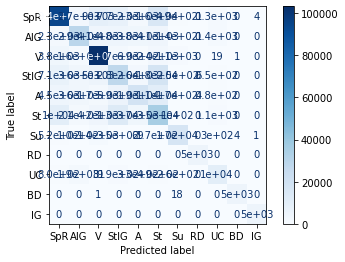

accuracy 0.7337341317649573
sensitivity 0.5004021975388934
specificity 0.8575971217792637


In [ ]:
confMat(clf,y_test,X_test)

KNN Confusion Matrix

In [ ]:
# for knn
confMat(knnclf,y_test,X_test)

y_test.shape [0 1 1 4 3]
prediction_xtest [3 0 2 0 1]
accuracy 0.4494047619047619
sensitivity 0.053636363636363635
specificity 0.7520080321285141


Gaussian Confusion Matrix

[[4511    0 2236  830    0 3873    0    0  775    0 1275]
 [  48    0 3809  353    0  584    0  142   47   17    0]
 [  45    0 8933  750    0 1005    0  620   44  101    2]
 [ 167    0 3621  746    0 1779    0    9  175    1    2]
 [  77    0 3643  385    0  784    0   39   61    8    3]
 [ 191    0 3593  884    0 2152    0    1  177    0    2]
 [  18    0 1472  197    0  285    0   17    7    1    3]
 [   0    0   39    0    0    0    0  137    0  324    0]
 [ 255    0  673  143    0  388    0    3   38    0    0]
 [   0    0   25    0    0    0    0  106    0  369    0]
 [   4    0    0    0    0    0    0    0    0    0  496]]


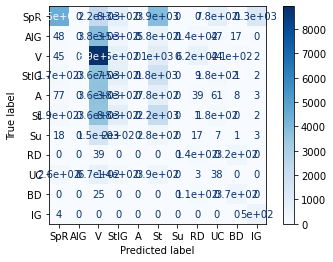

accuracy 0.8485703536493604
sensitivity 0.0
specificity 1.0


In [ ]:
confMat(gnb,y_test,X_test)

Random Forrest Consfusion Matrix

[[104726   2188  10944   1501    431  13776     24      6      0      0
       0]
 [  8958  22614   7165   1450   1090   8674     49      0      0      0
       0]
 [  6291   2078 102674   1081    154   1653    597      0      0      0
       0]
 [ 23689   8585   7190   4962   1001  19569      4      0      0      0
       0]
 [ 10391   6457   2557   1919   7615  16636     34      1      0      0
       0]
 [ 27634   6172   4658   3840   1490  26199      6      1      0      0
       0]
 [   923    953   8005    254      6    261   9598      0      0      0
       0]
 [     0      0      0      0      4      0      0   4996      0      0
       0]
 [  8278   2786    283    331    255   3049     18      0      0      0
       0]
 [     0      0      0      0      0      0     73      0      0   4927
       0]
 [     0      0      0      0      0      0      0      0      0      0
    5000]]


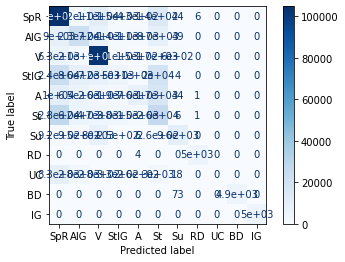

accuracy 0.5246309579232293
sensitivity 0.20789130154994576
specificity 0.7818582253910187


In [ ]:
confMat(clf,y_test,X_test)

KMeans Clusstering

In [ ]:
confMat(kmclf,y_test,X_test)

y_test.shape [2 4 2 3 2]
prediction_xtest [4 4 4 7 4]
accuracy 0.1274741564267603
sensitivity 0.9130699705494059
specificity 0.062098573456831854


DecisionTree ConfMat

In [ ]:
confMat(clf,y_test,X_test)

y_test.shape [0 1 1 4 3]
prediction_xtest [0 2 3 0 5]
accuracy 0.42937299122950373
sensitivity 0.09901873327386262
specificity 0.6204109706817986


# VISUALIZATION

Display Prediction on image. 

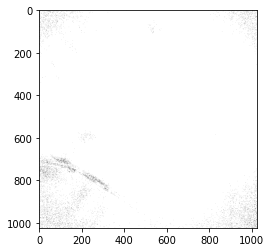

(1024, 1024)


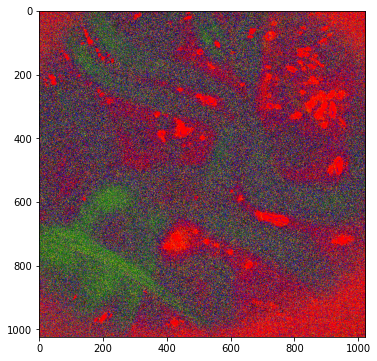

In [ ]:
import matplotlib.patches as mpatches
from skimage.measure import label, regionprops
spim, wl, colorimg, meta=read_stiff("drive/MyDrive/Ref 5-7/lower_5_icg.tif")
new_img = spim.reshape((spim.shape[0]*spim.shape[1]), spim.shape[2]) # (H*W,b)
image=spim[:,:,0]
thresholded_image = image > 0.05
fig, axs = plt.subplots(nrows=1, ncols=1)
axs.imshow(thresholded_image,'gray')
plt.show()


label_image = label(thresholded_image)
print(label_image.shape)  
props = regionprops(label_image)
# red,gray,green,black,purple,blue,yellow,aqua,brown,magenta,orange
color_dict={0:[255,0,0],1:[128,128,128],2:[0,128,0],3:[0,0,0],4:[128,0,128],5:[0,0,255],6:[255,255,0],7:[0,100,100],
            8:[165,42,42],9:[255,0,255],10:[255,165,0]}

for p in props:
  region_coords=p.coords
  for pixelcoord in  region_coords:
    colorimg[pixelcoord[1],pixelcoord[0]]=color_dict[label_img[pixelcoord[1],pixelcoord[0]]]

  
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(colorimg)
# plt.savefig("decisiontreeN1000k3")

